In [1]:
using Pkg; Pkg.activate()

using LinearAlgebra
using Distributions, Random
using LightGraphs
using Convex, ECOS
using Plots

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

#1 (generic function with 1 method)

# Make data

In [200]:
Random.seed!(2)
n = 1000

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate costs
f = rand(Exponential(5), n) .+ 2

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), n)
pmax = rand(Gamma(1.0, 1.0), m)

d = rand(Uniform(0.0, 1.05), n) .* gmax
τ = 1e-5

B = I;

case = ()

()

In [365]:
opf = PowerManagementProblem(f, d, pmax, gmax, A)
solve!(opf, ECOS_QUIET)

case = (d=d, g=evaluate(opf.g));

# Solve with ECOS

In [23]:
using BenchmarkTools

In [205]:
using CarbonNetworks: solvePMP

@time solvePMP(f, case, pmax, gmax, A)

ĝ, opf, θ = solvePMP(f, case, pmax, gmax, A);

  0.345399 seconds (90.03 k allocations: 71.729 MiB)


# Solve with custom solver

The optimization problem we're trying to solve is,

$$
\begin{array}{ll}
\text{minimize} & \frac{1}{2} g^T \mathbf{diag}(f) g + \frac{\tau}{2} \| p \|_2^2 \\
\text{subject to} 
& -p - p^{\max} \leq 0 \\
& p - p^{\max} \leq 0 \\
& -g \leq 0 \\
& g - g^{\max} \leq 0 \\
& Ap - g + d = 0
\end{array}
$$

Denote the dual variables $\lambda^-, \lambda^+, \mu^-, \mu^+, \nu$.

In [366]:
relu(x) = max(0, x)
relu(x::Array) = max.(0, x)

cost(g, p, f, τ) = (1/2)*g' * (f .* g) + (τ/2)*norm(p)^2

function lagrangian(g, p, λl, λu, μl, μu, ν; f=f, τ=1e-5, pmax=pmax, gmax=gmax, d=d, ρ=1.0)
    # Objective
    L = cost(g, p, f, τ)
    
    # Dual terms
    L += λl' * (-p - pmax) + λu' * (p - pmax)
    L += μl' * (-g) + μu' * (g - gmax)
    L += ν' * (A*p - g + d)
    
    # Augmented terms
    L += (ρ/2) * (norm(relu(-p - pmax))^2 + norm(relu(p - pmax))^2)
    L += (ρ/2) * (norm(relu(-g))^2 + norm(relu(g - gmax))^2)
    L += (ρ/2) * (norm(A*p - g + d)^2)
    
    return L
end

∇L_g(g, p, λl, λu, μl, μu, ν; f=f, τ=1e-5, pmax=pmax, gmax=gmax, d=d, ρ=1.0) = (
    f .* g
    + (μl + ρ*relu(-g)) .* (-1) #.* (-g .> 0)
    + (μu + ρ*relu(g - gmax)) .* (1) #.* (g - gmax .> 0)
    - ν - ρ*(A*p - g + d)
)

∇L_p(g, p, λl, λu, μl, μu, ν; f=f, τ=1e-5, pmax=pmax, gmax=gmax, d=d, ρ=1.0) = (
    τ*p
    + (λl + ρ*relu(-p - pmax)) .* (-1) #.* (-p - pmax .> 0)
    + (λu + ρ*relu(p - pmax)) .* (1) #.* (p - pmax .> 0)
    + A'ν + ρ*A' * (A*p - g + d)
)

∇L_p (generic function with 1 method)

In [390]:
function train!(g, p, λl, λu, μl, μu, ν; num_iter=10_000, f̂=f, ρ=ρ)
    lag_hist = [lagrangian(g, p, λl, λu, μl, μu, ν; ρ=ρ, f=f̂)]
    cost_hist = [cost(g, p, f̂, τ)]
    eq_hist = [A*p - g + d]
    ineq_hist = [relu([-p - pmax; p - pmax; -g; g - gmax])]
    true_g_hist = [g - ĝ]
    
    for iter in 1:num_iter
        dg = ∇L_g(g, p, λl, λu, μl, μu, ν; ρ=ρ, f=f̂)
        dp = ∇L_p(g, p, λl, λu, μl, μu, ν; ρ=ρ, f=f̂)

        dλl = relu(-p - pmax)
        dλu = relu(p - pmax)
        dμl = relu(-g)
        dμu = relu(g - gmax)
        dν = A*p - g + d

        α = 50.0 * (1000 / (1000 + iter)) #/ iter #.0 #(1/iter)
        #@show norm([dg; dp; dλl; dλu; dμl; dμu; dν])
        α /= norm([dg; dp; dλl; dλu; dμl; dμu; dν])
        #α = 0.0001

        @. g -= α*dg
        @. p -= α*dp

        @. λl += α*dλl
        @. λu += α*dλu
        @. μl += α*dμl
        @. μu += α*dμu
        @. ν += α*dν

        #push!(lag_hist, lagrangian(g, p, λl, λu, μl, μu, ν, ρ=ρ, f=f̂))
        push!(cost_hist, cost(g, p, f̂, τ))
        #push!(eq_hist, A*p - g + d)
        #push!(ineq_hist, relu([-p - pmax; p - pmax; -g; g - gmax]))
        push!(true_g_hist, g - ĝ)
    end
    
    return lag_hist, cost_hist, eq_hist, ineq_hist, true_g_hist
end

train! (generic function with 1 method)

In [391]:
using Profile

Random.seed!(5)

g, p = rand(n) .* gmax, 0.1 * randn(m) .* pmax
λl, λu, μl, μu, ν = rand(m), rand(m), rand(n), rand(n), randn(n)

Profile.clear()
lag_hist, cost_hist, eq_hist, ineq_hist, true_g_hist = 
    train!(g, p, λl, λu, μl, μu, ν; num_iter=100_000);

In [392]:
@show minimum(norm.(true_g_hist) / sqrt(n))
@show opf.problem.optval
@show cost(g, p, f, τ)

minimum(norm.(true_g_hist) / sqrt(n)) = 0.6275115188515439
opf.problem.optval = 807880.088916589
cost(g, p, f, τ) = 817836.0962695603


817836.0962695603

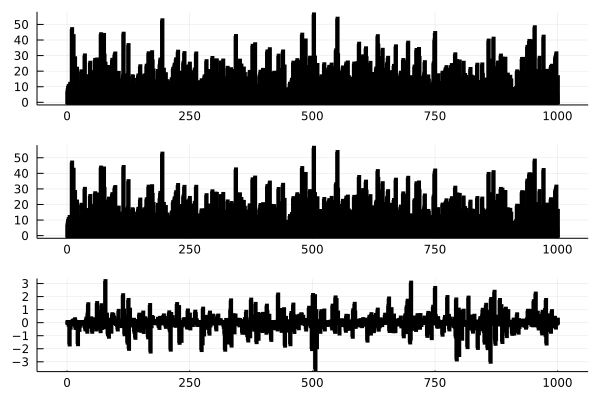

In [393]:
plot(bar(g), bar(ĝ), bar(g - ĝ), layout=(3, 1))

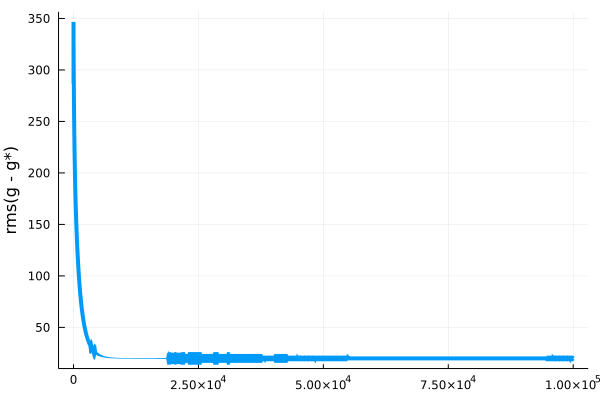

In [398]:
theme(:default, lw=4, label=nothing)

#plt2 = plot(cost_hist[2:end], ylabel="cost")
#hline!(plt2, [opf.problem.optval])

#plt3 = plot(maximum.(eq_hist)[2:end], ylabel="max(Ax - b)", yscale=:log10)
#plt4 = plot(maximum.(ineq_hist)[2:end], ylabel="max(F(x))", yscale=:log10)
plt5 = plot(norm.(true_g_hist), ylabel="rms(g - g*)")

#plot(plt5, plt3, plt4, layout=(3, 1))